In [ ]:
!pip install xgboost
!pip install tabulate
!pip install vaderSentiment

In [3]:
import warnings
import textblob

import numpy as np
import pandas as pd
import keras.utils as U
import keras.layers as L
import keras.models as M
import keras.optimizers as opt
import matplotlib.pyplot as plt

from utils import *
from doc_utils import *
from tabulate import tabulate
from sklearn.ensemble import *
from collections import Counter
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import RidgeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from nlp_utils import get_features, make_predictions
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import precision_score, recall_score, f1_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [10]:
plt.rcParams['figure.figsize'] = [20, 8]

# Read tweets csv
df = pd.read_json("../../data/TweetsConsolidated.json")

# Drop all-null rows if any
df.dropna(how='all', inplace=True)
# df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
# df_lost = pd.read_json("../../data/lostandfound_tweets.json")
# try:
#     # Drop all-null rows if any
#     df_lost.dropna(how='all', inplace=True)
#     df_lost.drop(columns=['Unnamed: 0'], inplace=True)
# except:
#     pass

In [11]:
lead_days = 2
days_window = 5

start_date = pd.to_datetime("23-feb-2019")
end_date = pd.to_datetime("03-may-2019")


labels = process_acled_csv("../../data/1900-01-01-2019-05-03-India.csv", 
                           top_locations=-1, 
                           start=start_date, 
                           end=end_date,
                           lead_days=lead_days,
                           days_window = days_window)

Data from 2019-02-23 to 2019-05-03  & Number of days - 70


In [12]:
clean = False
if not clean:
    df = clean_df(df)
    clean = True

Dropping 1 rows!


In [13]:
df.dropna(subset=['id'], inplace=True)
df = get_tweet_sentiment(df)

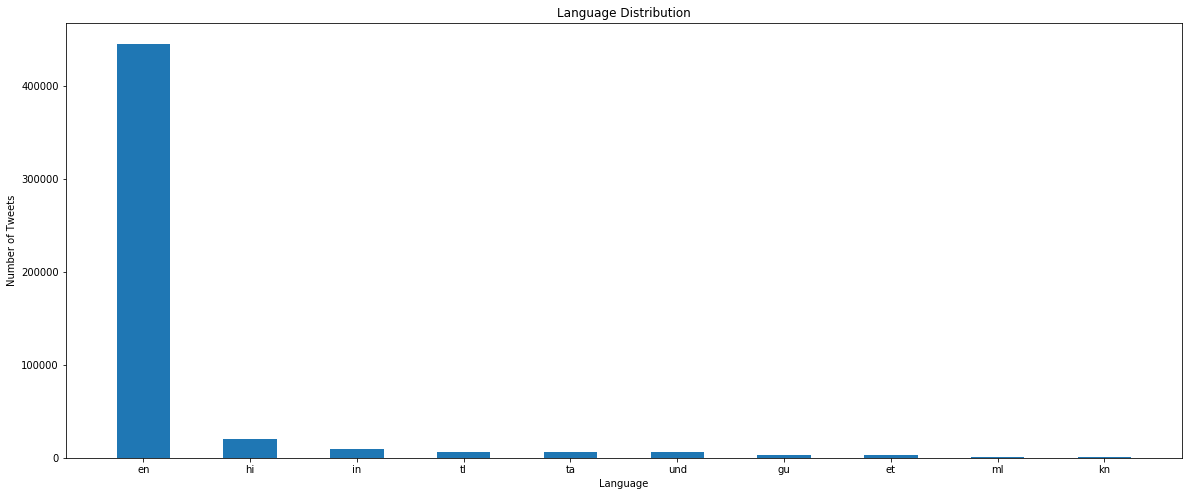

In [14]:
plot_counter(df['lang'], num_elements=10, xlabel="Language", ylabel="Number of Tweets", title="Language Distribution")

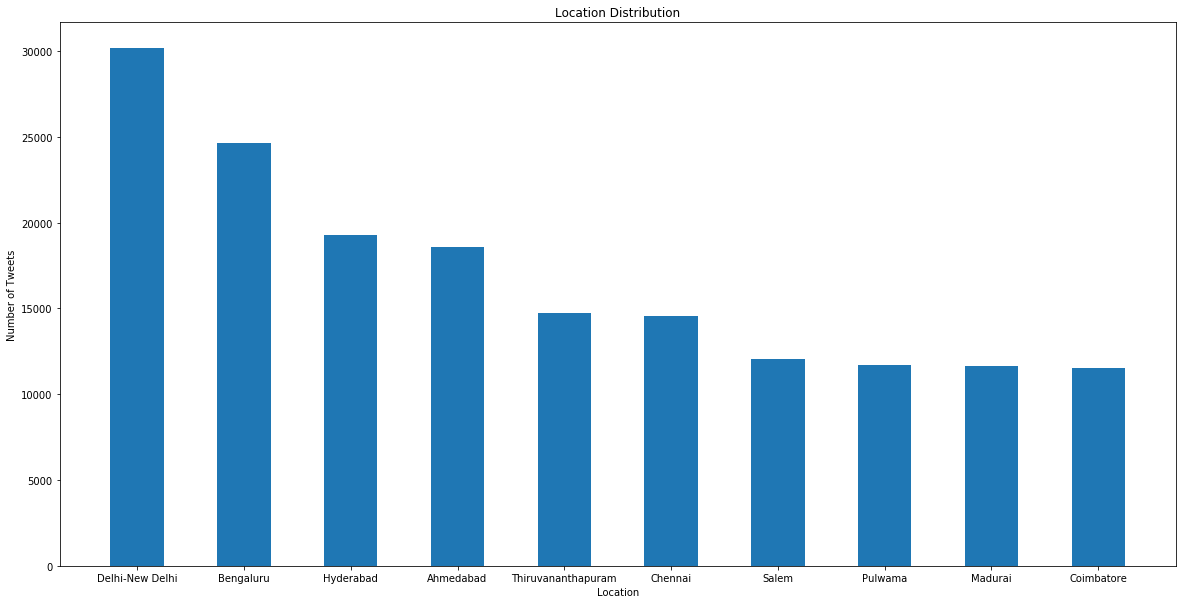

In [17]:
plot_counter([x for x in df['finallocation'] if x != "India"], num_elements=10, xlabel="Location", ylabel="Number of Tweets", title="Location Distribution")

In [18]:
df['created_at'] = pd.to_datetime(df['created_at'])
# Sort by time created
df.sort_values(by=['created_at'], inplace=True)

In [ ]:
print(start_date, end_date)
print(len(df))
df = df[df["finallocation"] != "India"]
print(len(df))
warnings.filterwarnings('ignore')
location_date_dict = interleave_location_and_date(df, "03-may-2019", "05-may-2019")
warnings.filterwarnings('default')

2019-02-23 00:00:00 2019-05-03 00:00:00
315033
315033


### Current Features
   * Number of tweets each day
   * Average pos, neg, neu and compound features
   * Tweet count with neg sentiment

### TODO
   * Hate speech
   * Violent speech

In [20]:
location_features_dict = {}
for location in location_date_dict:
    if location.lower() == "india":
        continue
    location_features_dict[location] = get_features(location_date_dict[location])
    print(location, "done")

Sangrur done
Jalandhar done
Amritsar done
Ludhiana done
Chandigarh done
Bathinda done
Patiala done
Bengaluru done
Delhi-New Delhi done
Gurgaon done
Karnal done
Thiruvananthapuram done
Lucknow done
Dehradun done
Pulwama done
Hyderabad done
Kolkata done
Ahmedabad done
Guwahati done
Chennai done
Salem done
Madurai done
Tiruchirappalli done
Coimbatore done
Puducherry done
Imphal done
Agartala done
Jammu done
Ranchi done
Shimla done
Patna done
Jaipur done
Srinagar done
Bhubaneswar done
Bangkok done


In [21]:
model = ExtraTreesClassifier(n_estimators=200, n_jobs=-1)
def make_predictions(location_features_dict, labels, model=None, permute=False, lead_days=2, days_window=5):
    """
    Input - 
            location_features_dict - The dict mapping from location to features
            labels - Label dict generated from process_acled_csv(..)
            model - Specific sklearn model to evaluate/benchmark performance
            permute - Permute the data before train-test split
    Returns - None
    """
    # Table for presenting on tabulate
    result_table = []

    # Suppress warnings for divide-by-zero error
    warnings.filterwarnings("ignore")

    # Compute intersection for locations present on both dicts
    common_locations = set(location_features_dict.keys()) & set(labels.keys())

    # Sorted for clarity
    common_locations = sorted(list(common_locations))

    for common_location in common_locations:
        # Get data and labels
        X, y = location_features_dict[common_location], labels[common_location]
        X, y = np.array(X), np.array(y)

        # Eliminate last days to match labels.shape
        X = X[:-(lead_days + days_window)]

        # Permute randomly if specified
        if permute:
            p = np.random.permutation(len(X))
            X, y = X[p], y[p]

        # Split data into train & test - 75% & 25%
        split = int(0.75 * len(X))
        xtrain, ytrain = X[:split], y[:split]
        xtest, ytest = X[split:], y[split:]
        
        # Default model
        if model is None:
            model = xgboost.XGBClassifier(n_estimators=200, n_jobs=-1)

        # Fit the train data
        model.fit(xtrain, ytrain)

        # Make predictions
        ypred = model.predict(xtest)
                
        # Compute metrics
        train_acc = model.score(xtrain, ytrain)
        test_acc = model.score(xtest, ytest)
        precision = precision_score(ytest, ypred, average='weighted', labels=np.unique(ypred))
        recall = recall_score(ytest, ypred, average='weighted', labels=np.unique(ypred))
        f1 = f1_score(ytest, ypred, average='weighted', labels=np.unique(ypred))
        
        
        # Add row to result_table
        result_row = [
                      common_location,
                      np.round(train_acc, 2), np.round(test_acc, 2),
                      np.round(precision, 2), np.round(recall, 2),
                      np.round(f1, 2), np.round(np.sum(y) / len(y), 2)
                     ]
                      
        result_table.append(result_row)

    # Average stats
    # Turns out median is kind of useless
    result_table_copy = (np.array(result_table)[:, 1:]).astype(np.float32)
    averages = np.round(np.mean(result_table_copy, axis=0), 2)
    
    # Sort by test accuracy
    result_table = sorted(result_table, key=lambda x: -x[-2])


    # Add them to the existing result table
    result_table.append(["Average"] + averages.tolist())

    # Header for table
    header = ["Location", "Train Accuracy", "Test Accuracy",
              "Precision", "Recall", "F1 Score", "+'s in data"]
    
    # Print tabulated result
    print(tabulate(result_table, 
                   tablefmt="pipe", 
                   stralign="center", 
                   headers=header))
    
    # Unsuppress warning
    warnings.filterwarnings("default")
    return

make_predictions(location_features_dict, labels, permute=False, model=model)

|      Location      |   Train Accuracy |   Test Accuracy |   Precision |   Recall |   F1 Score |   +'s in data |
|:------------------:|-----------------:|----------------:|------------:|---------:|-----------:|--------------:|
|     Bengaluru      |             1    |            0.94 |        0.94 |     1    |       0.97 |          0.9  |
|     Chandigarh     |             1    |            0.94 |        0.94 |     1    |       0.97 |          0.9  |
|      Dehradun      |             1    |            0.94 |        1    |     0.94 |       0.97 |          0.19 |
|  Delhi-New Delhi   |             1    |            0.94 |        0.94 |     1    |       0.97 |          0.97 |
|       Jammu        |             1    |            0.94 |        0.94 |     1    |       0.97 |          0.98 |
|      Ludhiana      |             1    |            0.94 |        0.94 |     1    |       0.97 |          0.95 |
|      Srinagar      |             1    |            0.94 |        0.94 |     1    |    

In [62]:
result_dict = {}
for location in location_features_dict:
    if location not in labels:
        continue
    x = location_features_dict[location]
    x = [[0, 0, 0, 0, 0, 0]] + x 
    x = [[0, 0, 0, 0, 0, 0]] + x
    y = labels[location].tolist()
    y = [1] + y
    y = [0] + y
    y = np.array(y, dtype=np.float32)
    xtrain, ytrain = x[:50], y[:50]
    xtest, ytest = x[50:], y[50:]
    model.fit(xtrain, ytrain)
    
    dates = location_date_dict[location].keys()
    for i, date in enumerate(dates):
        if location not in result_dict:
            result_dict[location] = {}
        prob = model.predict_proba(np.reshape(x[i + 2], (1, -1))).flatten()
        result_dict[location][str(pd.to_datetime(date).date())] = prob[1]
    print(location, "done")

Sangrur done
Jalandhar done
Amritsar done
Ludhiana done
Chandigarh done
Bathinda done
Patiala done
Bengaluru done
Delhi-New Delhi done
Gurgaon done
Karnal done
Thiruvananthapuram done
Lucknow done
Dehradun done
Pulwama done
Hyderabad done
Kolkata done
Ahmedabad done
Guwahati done
Chennai done
Salem done
Madurai done
Tiruchirappalli done
Coimbatore done
Puducherry done
Imphal done
Agartala done
Jammu done
Ranchi done
Shimla done
Patna done
Jaipur done
Srinagar done
Bhubaneswar done


In [66]:
import json
with open("demo.json", 'w') as f:
    f.write(json.dumps(result_dict))

In [22]:
def generate_LSTM_model(history):
    """ Generates a compiled LSTM model
    
    Input - Number of history points considered
    """
    model = M.Sequential()
    model.add(L.InputLayer(input_shape=(history, 6)))
    model.add(L.LSTM(10))
    model.add(L.Dense(20))
    model.add(L.Dense(2))
    model.add(L.Softmax())
    
    model.compile(loss="categorical_crossentropy", optimizer=opt.Adam(0.01))
    return model

def generate_CNN_model(history):
    """ Generate a compiled 1D CNN model
    
    Input - Number of history points considered
    """
    model = M.Sequential()
    model.add(L.InputLayer(input_shape=(history, 6)))
    model.add(L.Conv1D(32, kernel_size=3))
    model.add(L.Conv1D(16, kernel_size=1))
    model.add(L.Flatten())
    model.add(L.Dense(20))
    model.add(L.Dense(2))
    model.add(L.Softmax())

    model.compile(loss="categorical_crossentropy", optimizer=opt.Adam(0.01))
    return model

def make_deep_predictions(location_features_dict, labels, model=None, permute=False, lead_days=2, days_window=5, history=3):
    """
    Input - 
            location_features_dict - The dict mapping from location to features
            labels - Label dict generated from process_acled_csv(..)
            model - Specific sklearn model to evaluate/benchmark performance
            permute - Permute the data before train-test split
            history - The number of data points for contextualization
    Returns - None
    """
    # Table for presenting on tabulate
    result_table = []

    # Compute intersection for locations present on both dicts
    common_locations = set(location_features_dict.keys()) & set(labels.keys())

    # Sorted for clarity
    common_locations = sorted(list(common_locations))

    for common_location in common_locations:
        # Get data and labels
        X, y = location_features_dict[common_location], labels[common_location]
        X, y = np.array(X), np.array(y)

        # Eliminate last days to match labels.shape
        X = X[:-(lead_days + days_window)]
        
        # Generate data for LSTM/CNN
        # Basically, use points from i to i + history
        # and predict for i + history + 1
        temp_X, temp_y = [], []
        for i in range(len(X) - history - 1):
            temp_X.append(X[i: i + history])
            temp_y.append(y[i + history + 1])
        
        X, y = np.array(temp_X), np.array(temp_y)
        
        # Permute randomly if specified
        if permute:
            p = np.random.permutation(len(X))
            X, y = X[p], y[p]

        # Split data into train & test - 75% & 25%
        split = int(0.75 * len(X))
        
        xtrain, ytrain = X[:split], y[:split]
        xtest, ytest = X[split:], y[split:]
        
        if isinstance(model, str):
            assert (history != 0)
            if model.lower() == "cnn":
                model = generate_CNN_model(history)
            elif model.lower() == "lstm":
                model = generate_LSTM_model(history)

        # Convert to one-hot encoding 
        ytrain, ytest = U.to_categorical(ytrain, num_classes=2), U.to_categorical(ytest, num_classes=2)
        
        # Fit the train data
        model.fit(xtrain, ytrain, epochs=100, verbose=0)

        # Make predictions
        ypred = model.predict(xtest)
        ytrain_pred = model.predict(xtrain)

        # Uncategorize
        uncategorize = lambda x: np.argmax(x, axis=1)

        ytrain, ytest = uncategorize(ytrain), uncategorize(ytest)
        ytrain_pred, ypred = uncategorize(ytrain_pred), uncategorize(ypred)

        # Compute metrics
        train_acc = np.mean(ytrain_pred == ytrain)
        test_acc = np.mean(ytest == ypred)
        precision = precision_score(ytest, ypred, average='weighted', labels=np.unique(ypred))
        recall = recall_score(ytest, ypred, average='weighted', labels=np.unique(ypred))
        f1 = f1_score(ytest, ypred, average='weighted', labels=np.unique(ypred))

        # Add row to result_table
        result_row = [common_location,
                      np.round(train_acc, 2), np.round(test_acc, 2),
                      np.round(precision, 2), np.round(recall, 2),
                      np.round(f1, 2),
                      np.round(np.sum(y) / len(y), 2)]
        result_table.append(result_row)

    # Average stats
    # Turns out median is kind of useless
    result_table_copy = (np.array(result_table)[:, 1:]).astype(np.float32)
    result_table = sorted(result_table, key=lambda x: -x[2])
    averages = np.round(np.mean(result_table_copy, axis=0), 2)

    # Add them to the existing result table
    result_table.append(["Average"] + averages.tolist())

    # Header for table
    header = ["Location", "Train Accuracy", "Test Accuracy",
              "Precision", "Recall", "F1 Score", "+'s in data"]
    
    # Print tabulated result
    print(tabulate(result_table, 
                   tablefmt="pipe", 
                   stralign="center", 
                   headers=header))
    
    

In [24]:
make_deep_predictions(location_features_dict, labels, permute=False, model="lstm", history=7)

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


|      Location      |   Train Accuracy |   Test Accuracy |   Precision |   Recall |   F1 Score |   +'s in data |
|:------------------:|-----------------:|----------------:|------------:|---------:|-----------:|--------------:|
|      Dehradun      |             0.95 |            1    |        1    |     1    |       1    |          0.07 |
|  Tiruchirappalli   |             0.71 |            1    |        1    |     1    |       1    |          0.36 |
|      Bathinda      |             0.88 |            0.93 |        0.93 |     1    |       0.96 |          0.89 |
|     Bengaluru      |             0.93 |            0.93 |        0.93 |     1    |       0.96 |          0.93 |
|     Chandigarh     |             0.9  |            0.93 |        0.93 |     1    |       0.96 |          0.91 |
|  Delhi-New Delhi   |             0.98 |            0.93 |        0.93 |     1    |       0.96 |          0.96 |
|     Jalandhar      |             0.85 |            0.93 |        0.93 |     1    |    